In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 20

In [3]:
annotations_df = pd.read_csv(r"C:\Users\AdmPDI\Documents\cnn-dog-person-classifier\modified_voc\annotations.csv")

In [4]:
annotations_df["image"].items

<bound method Series.items of 0       image_0062.jpg
1       image_0238.jpg
2       image_0674.jpg
3       image_0747.jpg
4       image_0252.jpg
             ...      
1197    image_1656.jpg
1198    image_0308.jpg
1199    image_1370.jpg
1200    image_1658.jpg
1201    image_1622.jpg
Name: image, Length: 1202, dtype: object>

In [5]:
annotations_df.head()

,image,dog,person,split
0,image_0062.jpg,0,0,train
1,image_0238.jpg,0,0,test
2,image_0674.jpg,0,1,train
3,image_0747.jpg,0,1,test
4,image_0252.jpg,0,0,train


In [6]:
annotations_df['split'].value_counts()['train']*100/len(annotations_df.index)

72.12978369384359

In [7]:
annotations_df["labels"] = (
    annotations_df.filter(['dog', 'person'])
    .apply(lambda row: row.to_numpy(), axis=1)
)
annotations_df.drop(["dog", "person"],axis=1, inplace=True)
annotations_df.sort_values(by="split", inplace=True)
annotations_df.head()

,image,split,labels
689,image_0208.jpg,test,"[0, 0]"
291,image_1360.jpg,test,"[0, 1]"
290,image_0894.jpg,test,"[0, 1]"
535,image_1654.jpg,test,"[0, 1]"
288,image_1229.jpg,test,"[0, 1]"


In [8]:
def load_image(image_path):
    parent_folder_name = "modified_voc"
    image_path = os.path.join(parent_folder_name, image_path)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_images(images: pd.Series)-> list:
    image_list = []
    for _, image_path in tqdm(images.items(), total=images.size):
        image_list.append(load_image(image_path))
    return image_list

In [9]:
images = load_images(images=annotations_df["image"])

  0%|          | 0/1202 [00:00<?, ?it/s]

100%|██████████| 1202/1202 [00:02<00:00, 490.00it/s]


In [10]:
labels = annotations_df["labels"].tolist()

In [11]:
data = tf.data.Dataset.from_tensor_slices((images, labels))

In [12]:
num_test_samples = annotations_df["split"].value_counts()["test"]

In [13]:
test_data = data.take(num_test_samples)
val_data = test_data.skip(100)
test_data = test_data.take(100)
train_data = data.skip(num_test_samples)

In [14]:
val_data = val_data.batch(BATCH_SIZE)
train_data = train_data.batch(BATCH_SIZE)

In [15]:
backbone_model = keras.applications.MobileNet(include_top=False, weights="imagenet")
backbone_model.trainable = False

In [24]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.mobilenet.preprocess_input(inputs)
x = backbone_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(units=2, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                      

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.Precision(class_id=0, name="Precision (Dog)"), keras.metrics.Recall(class_id=0, name="Recall (Dog)"), keras.metrics.Precision(class_id=1, name="Precision (Person)"), keras.metrics.Recall(class_id=1, name="Recall (Person)")], run_eagerly=True)

In [26]:
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/20
28/28 [==============================] - 50s 2s/step - loss: 0.5013 - Precision (Dog): 0.1915 - Recall (Dog): 0.0841 - Precision (Person): 0.7094 - Recall (Person): 0.7782 - val_loss: 0.4097 - val_Precision (Dog): 0.4000 - val_Recall (Dog): 0.0667 - val_Precision (Person): 0.7714 - val_Recall (Person): 0.8308
Epoch 2/20
28/28 [==============================] - 54s 2s/step - loss: 0.3379 - Precision (Dog): 0.6667 - Recall (Dog): 0.2430 - Precision (Person): 0.8433 - Recall (Person): 0.8416 - val_loss: 0.3398 - val_Precision (Dog): 0.8333 - val_Recall (Dog): 0.1667 - val_Precision (Person): 0.8085 - val_Recall (Person): 0.8769
Epoch 3/20
28/28 [==============================] - 55s 2s/step - loss: 0.2756 - Precision (Dog): 0.7586 - Recall (Dog): 0.4112 - Precision (Person): 0.8952 - Recall (Person): 0.8455 - val_loss: 0.3104 - val_Precision (Dog): 0.8571 - val_Recall (Dog): 0.2000 - val_Precision (Person): 0.8116 - val_Recall (Person): 0.8615
Epoch 4/20
28/28 [================

In [ ]:
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [1]:
import pickle

with open("history.pkl", "rb") as f:
    history = pickle.load(f)

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

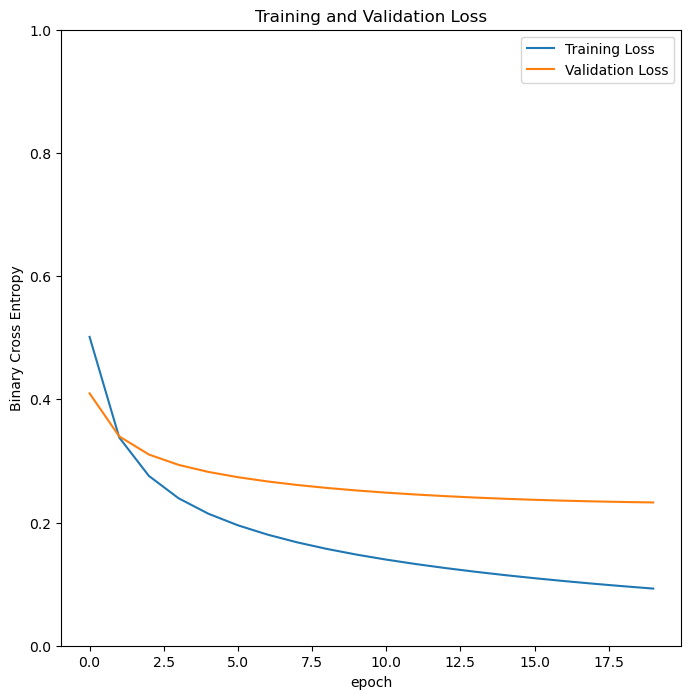

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("loss_plot.png")

In [31]:
dog_precision = history.history['val_Precision (Dog)']
dog_recall = history.history['val_Recall (Dog)']
person_precision = history.history['val_Precision (Person)']
person_recall = history.history['val_Recall (Person)']

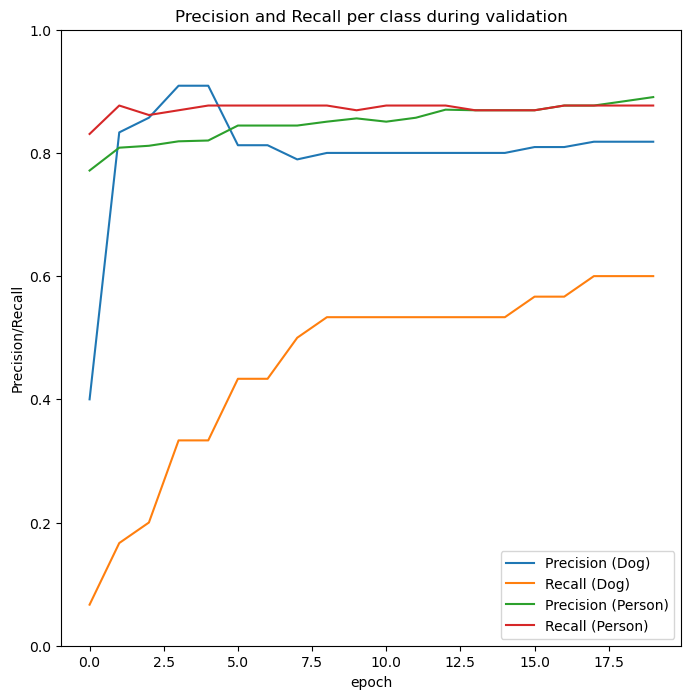

In [32]:
plt.figure(figsize=(8,8))
plt.plot(dog_precision, label='Precision (Dog)')
plt.plot(dog_recall, label='Recall (Dog)')
plt.plot(person_precision, label='Precision (Person)')
plt.plot(person_recall, label='Recall (Person)')
plt.legend(loc='lower right')
plt.ylabel('Precision/Recall')
plt.ylim([0,1.0])
plt.title('Precision and Recall per class during validation')
plt.xlabel('epoch')
plt.show()

In [40]:
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
image, label = next(iter(test_data))
image.shape

TensorShape([32, 224, 224, 3])

In [46]:
predictions = model.predict(image)
binary_preds = (predictions > 0.5).astype(int)
for pred, label in zip(binary_preds, labels):
    print(pred==label)

1/1 [==============================] - 1s 643ms/step
[ True False]
[ True  True]
[ True  True]
[ True  True]
[ True False]
[ True False]
[ True  True]
[False False]
[ True  True]
[ True False]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[False  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[False  True]
[ True False]
[ True  True]
[ True  True]
